In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras import Input, regularizers

# Scikit-learn Libraries
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt


### Data Partitioning for Model Training and Testing

- We load the cleaned and labeled dataset (`labeled_desc_post_eda.csv`) and remove any rows with missing values to ensure data integrity.
- The dataset is then split into training and testing sets using an 80/20 split, ensuring that 80% of the data is used for training the model, and 20% is reserved for testing its performance.
- **`train_test_split`** is used with a fixed random seed (`random_state=9000`) to ensure reproducibility of the results.


In [2]:
#Create data partitions
data = pd.read_csv(f'labeled_desc_post_eda.csv', encoding='utf-8')
data = data.dropna()

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['out'], test_size=0.2, random_state=9000)

### Tokenization and Padding

- We set up tokenization with a limit of 10,000 unique words and a max sentence length of 100 tokens.
- The **`Tokenizer`** is initialized and fit on the training data, converting text into sequences of integers.
- Both training and test sets are tokenized into sequences and then padded to ensure they all have the same length of 100 tokens.


In [3]:
# Tokenization and padding
max_words = 10000  # Number of unique tokens to consider
max_len = 100  # Max length of each sentence

# Initialize Tokenizer and fit on the training data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences (tokenized integers)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure equal length (max_len)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


### LSTM Model with L2 Regularization and Dropout

- Building LSTM model using **`Sequential`**, starting with an input layer for sequences of length 100.
- The **`Embedding`** layer converts words into dense vectors of size 128.
- Two **LSTM** layers are added, the first with **`return_sequences=True`** to allow stacking, both with L2 regularization to prevent overfitting.
- **Dropout** layer is added to further reduce overfitting.
- The output is flattened and passed through a **Dense** layer with **sigmoid activation** for binary classification.


In [4]:

# Build the LSTM model with L2 Regularization and Dropout
model = Sequential()

# Define the input layer
model.add(Input(shape=(max_len,)))

# Embedding layer
model.add(Embedding(input_dim=max_words, output_dim=128))

# LSTM layer with return_sequences=True for stacking more layers (with L2 regularization)
model.add(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))

# Another LSTM layer without return_sequences (with L2 regularization)
model.add(LSTM(64, kernel_regularizer=regularizers.l2(0.01)))

# Adding a Dropout layer to reduce overfitting
model.add(Dropout(0.5))

# Flatten the output before feeding into the Dense layer
model.add(Flatten())

# Output layer with sigmoid activation for binary classification (with L2 regularization)
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))


In [5]:

# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,461,057 (5.57 MB)

 Trainable params: 1,461,057 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

### Optimizer and Model Compilation

- **Exponential decay schedule** is set for the learning rate, starting at 0.001 and gradually decreasing over time.
- Using the **Adam optimizer** with the custom learning rate schedule and standard parameters, chosen for its efficiency and adaptability, handling sparse gradients well.
- Compiling the model using **binary crossentropy loss** (ideal for binary classification tasks like ours) and **accuracy** as the primary metric, with **recall** added to track the model's sensitivity.


In [6]:

# Define an exponential decay schedule for the learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

# Custom optimizer with learning rate schedule
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)

# Compile the model with custom optimizer, binary crossentropy loss, and additional metrics
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Recall(name='recall')])


### Training with Class Weights and Early Stopping

- **Class weights** are calculated to handle imbalanced classes, ensuring each class is weighted based on its frequency in the data.
- An **early stopping** callback is used to stop training when the validation loss stops improving after 3 epochs, restoring the best model weights.
- The model is trained for up to 10 epochs with a batch size of 64, using 20% of the data for validation and applying class weights.


In [8]:

# Ensure y_train is in the correct format (integer labels)
if isinstance(y_train, pd.Series):  # If it's a pandas Series, convert to NumPy array
    y_train = y_train.values

# Class balance: Calculate class weights
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)

# Convert to dictionary with correct mapping between class labels and weights
class_weight_dict = {int(label): weight for label, weight in zip(unique_classes, class_weights)}

# Early stopping: Stop training when the validation loss doesn't improve after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights and early stopping
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.2, 
                    class_weight=class_weight_dict, callbacks=[early_stopping])

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.5727 - loss: 4.2644 - recall: 0.2053 - val_accuracy: 0.6048 - val_loss: 3.6630 - val_recall: 0.1091
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.6726 - loss: 3.4964 - recall: 0.1624 - val_accuracy: 0.6855 - val_loss: 3.0027 - val_recall: 0.6000
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.7066 - loss: 2.8488 - recall: 0.6017 - val_accuracy: 0.6774 - val_loss: 2.4447 - val_recall: 0.6000
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.7400 - loss: 2.3105 - recall: 0.6899 - val_accuracy: 0.6855 - val_loss: 2.0299 - val_recall: 0.8000
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.7759 - loss: 1.8565 - recall: 0.8093 - val_accuracy: 0.7500 - val_loss: 1.6387 - val_recall: 0.7273
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.8885 - loss: 1.4340 - recall: 0.8636 - val_accuracy: 0.7984 - val_loss: 1.3380 - val_recall: 0.8000
Epoch 7/10
8/8 ━

### Model Evaluation on Test Data

- The model predicts on the test data, and predictions are **thresholded at 0.5**, converting probabilities into binary class labels (0 or 1).


In [14]:
# Evaluate the model on test data
y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype("int32")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


In [19]:
print(classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90        94
         1.0       0.86      0.80      0.83        61

    accuracy                           0.87       155
   macro avg       0.87      0.86      0.86       155
weighted avg       0.87      0.87      0.87       155



### Model Performance 

- For class **0** (non-qualified), the model shows **88% precision** (correctly identified 0's out of all predicted 0's) and **91% recall** (found 91% of all true 0's), with an **F1-score of 0.90** (balance of precision and recall).
- For class **1** (qualified), it has **86% precision** and **80% recall**, with an **F1-score of 0.83**.
- Overall **accuracy is 87%**, meaning the model correctly predicted 87% of the test cases.
- The **macro average** shows equal weight for both classes, while the **weighted average** takes class size into account, both close to 87%.


### Plotting Training Metrics

- This function plots the training and validation accuracy, and if available, recall over the epochs to visualize model performance.


In [9]:
# Plot accuracy and recall during training
def plot_training_metrics(history):
    # Plot Accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('LSTM Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Check for recall metric in history keys
    recall_key = [key for key in history.history.keys() if 'recall' in key]
    if recall_key:
        # Plot Recall if available
        plt.plot(history.history[recall_key[0]], label='Train Recall')
        plt.plot(history.history['val_' + recall_key[0]], label='Validation Recall')
        plt.title('LSTM Model Recall')
        plt.ylabel('Recall')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()
    else:
        print("Recall metric not found in history")



### Plotting Confusion Matrix

- This function generates a heatmap of the confusion matrix and displays model accuracy in the plot title.


In [10]:


def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate accuracy
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    
    # Set the title with accuracy
    plt.title(f"{title}\nAccuracy: {accuracy * 100:.0f}%")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


### Plotting ROC Curve

- This function plots the ROC curve for the model, showing its true positive rate against the false positive rate and calculates the AUROC score.


In [11]:

# Plot ROC Curve
def plot_roc_curve(y_true, y_proba, model_name="LSTM"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUROC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for LSTM Model')
    plt.legend(loc='lower right')
    plt.show()

### Confusion Matrix - Results

- Overall accuracy of **89%**.
- The model shows better performance for class 0, with a higher count of true positives compared to class 1, where the misclassification rate is higher.


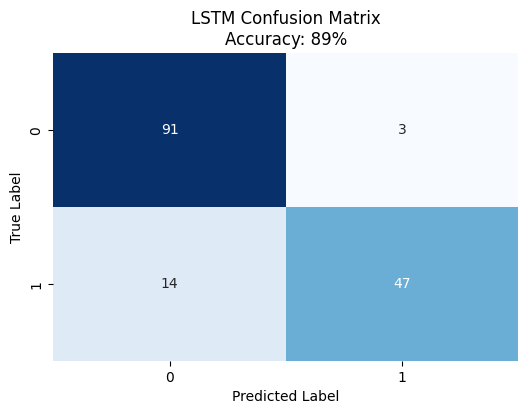

In [15]:
# Plot Confusion Matrix for LSTM Model
plot_confusion_matrix(y_test, y_pred_lstm, title="LSTM Confusion Matrix")


### Training Metrics - Results

- The **Recall** plot shows both training and validation recall improving over the epochs. Training recall increases quickly, reaching nearly 1.0 by the 7th epoch, while validation recall stabilizes around 0.8 after some fluctuation.
  
- The **Accuracy** plot highlights steady improvement for both training and validation accuracy. Training accuracy surpasses 95% by the final epoch, while validation accuracy reaches just under 90%, showing consistent progress.

- There is a noticeable gap between training and validation metrics, suggesting **slight overfitting**, but the overall trend indicates that the model generalizes fairly well, with validation performance stabilizing.


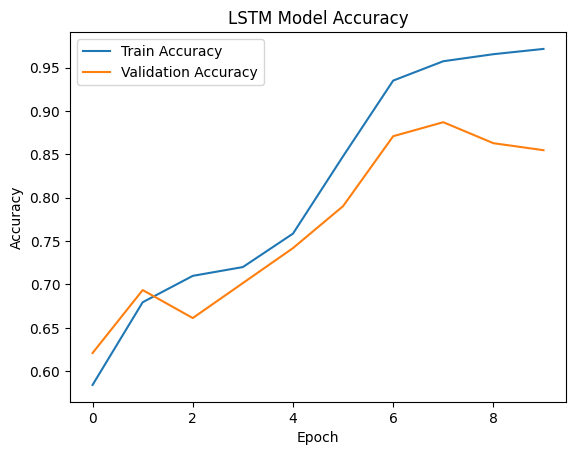

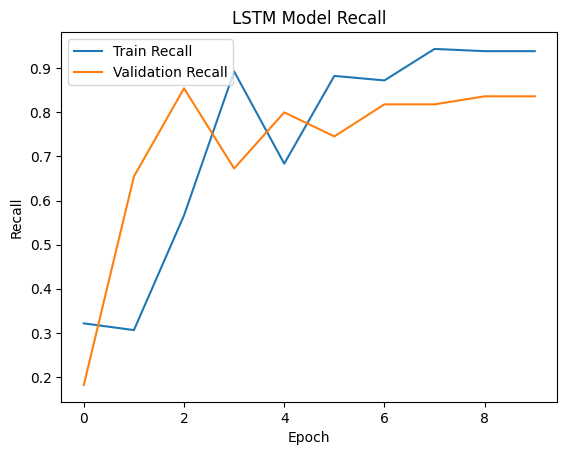

In [23]:

# Plot training accuracy and recall
plot_training_metrics(history)


### Interpretation of ROC Curve

- The **AUROC score of 0.9486** indicating excellent model performance, with the model effectively distinguishing between the two classes.
- The curve being close to the top-left corner shows that the model has a high true positive rate with a low false positive rate, indicating strong predictive power.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


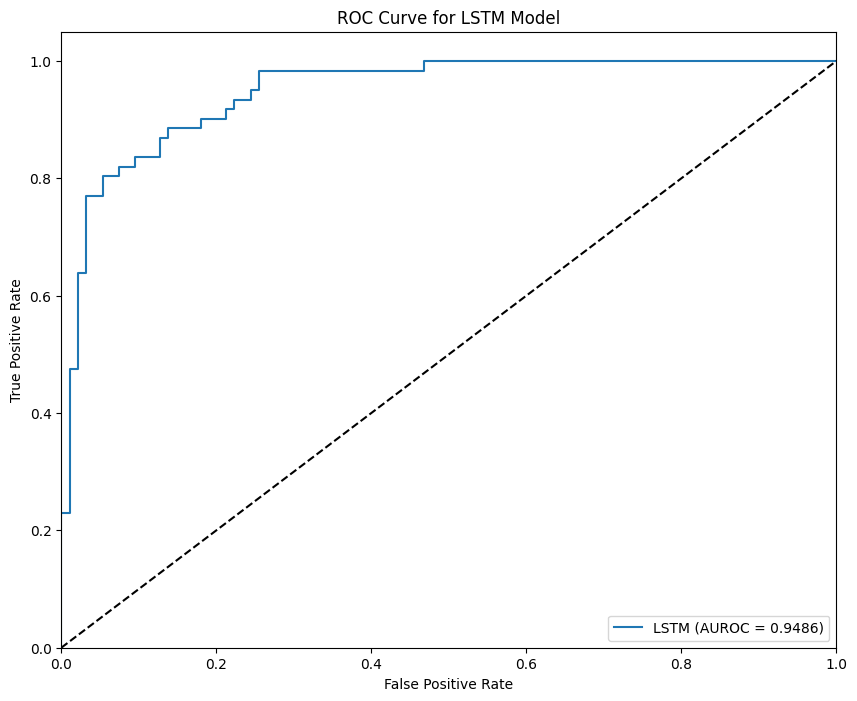

In [16]:

# Compute probabilities for ROC curve
y_proba_lstm = model.predict(X_test_pad).ravel()  # LSTM predicted probabilities
# Plot ROC Curve
plt.figure(figsize=(10, 8))
plot_roc_curve(y_test, y_proba_lstm, "LSTM")


### Model Comparison: Naive Bayes vs. LSTM Classifier

Now that I've tested both the Naive Bayes and LSTM models, let's compare them based on their confusion matrices, ROC curves, and key metrics like accuracy and recall.

#### Naive Bayes Classifier (Accuracy: 91%, AUROC: 0.96)

- Naive Bayes has good balance between precision and recall, especially with fewer false negatives. It also had the **highest AUROC** (0.96), making it the best performer for our task.
- While the best model overall, Naive Bayes might not capture complex patterns in the data as well as deep learning models like LSTM.

#### LSTM Classifier (Accuracy: 87%, AUROC: 0.95)

- LSTM did well, with 87% accuracy and a strong AUROC of 0.95. It’s great at handling sequences in the text, making it useful for this kind of problem.
- LSTM had more false positives and false negatives than Naive Bayes. It performs well but might miss some edge cases.

### Summary

- **Naive Bayes**: Best accuracy and AUROC (91%, 0.96), making it ideal for simpler patterns.
- **LSTM**: With 87% accuracy and 0.95 AUROC, might be good option in complex text patterns but slightly more prone to mistakes.

### Next Step: BERT Model

While Naive Bayes and LSTM both performed well, BERT might be able to take it further. Since **BERT** understands word context better, it could outperform these models, especially when dealing with job descriptions that have nuanced language.

In the next step, I’ll test a **BERT model** to see how it compares and if it can reduce the misclassifications we’ve seen so far.


In [18]:
import joblib

# Save tokenizer
joblib.dump(tokenizer, 'lstm_tokenizer.pkl')

model.save('lstm_clasifier.keras')